# Train pertained AlexNet model to recognize voice of people **Base Dataset Mixing Augmented**  

In [22]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from enum import Enum
import pandas as pd
from pathlib import Path
from torchvision.transforms.functional import normalize
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [23]:
import sys
sys.path.append('../')
DATASET_PATH = '../dataset/'
DATA_PATH = '../data/'
MODEL_SAVE_PATH = '../model_save/'
SAMPLE_RATE=16000
BATCH_SIZE = 24

In [24]:
def filter_sample_by_clients_ids(data: pd.DataFrame, max_count: int = 500, min_count: int = 4):
	sample_count = data['client_id'].value_counts()
	clients_ids = [e for e in sample_count[sample_count < max_count][sample_count > min_count].index]
	return data[data['client_id'].isin(clients_ids)]

def concatenation(train_data: pd.DataFrame, anchor: pd.DataFrame, posneg: pd.DataFrame) -> pd.DataFrame:
		data_particle_case = pd.DataFrame(columns=['anchor_client_id', 'anchor_path', 'posneg_client_id', 'posneg_path', 'anchor_source', 'posneg_source'])
		data_particle_case[['anchor_client_id', 'anchor_path', 'anchor_source']] = anchor
		data_particle_case[['posneg_client_id', 'posneg_path', 'posneg_source']] = posneg
		return pd.concat([train_data, data_particle_case], ignore_index=True)

def data_generation_base(data: pd.DataFrame, data_frac: int = 1):
	client_ids = data['client_id'].unique()
	data['source'] = 'original'
	
	res_data = pd.DataFrame(columns=['anchor_client_id', 'anchor_path', 'posneg_client_id', 'posneg_path', 'anchor_source', 'posneg_source'])
	for id in client_ids:
		client_id_sample = data[data['client_id'] == id] 
		no_client_id_sample = data[data['client_id'] != id]

		anchor_original = client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		positive_original = client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		res_data = concatenation(res_data, anchor_original, positive_original)

		anchor_neg_original = client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		negative_generated = no_client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		res_data = concatenation(res_data, anchor_neg_original, negative_generated)
	return res_data

In [25]:
import librosa

from src.columns.base_dataset_column import DatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation

class UniversalDS(Dataset):
	def __init__(
		self,
		voice_dataset,
		voice_data_path,
		generated_voice_dataset = None,
		generated_voice_data_path = None,
		sample_rate=16000,
		duration=3,
		transform=None
	):
		self.voice_dataset = voice_dataset
		self.generated_voice_dataset = generated_voice_dataset
		self.voice_data_path = str(voice_data_path)
		self.generated_voice_data_path = str(generated_voice_data_path)
		self.duration = duration
		self.sample_rate = sample_rate
		if transform is not None:
			self.transform = transform
		else:
			self.transform = CompositeTransformation(
				[
					ResampleTransform(target_sample_rate=sample_rate),
					CustomAdjustDurationTransform(duration_seconds=duration),
					ToMelSpectrogramTransform(
						sample_rate=sample_rate, n_mels=64, n_fft=512)
				]
			)
		self.mix_dataset()

	def __len__(self):
		return len(self.temp_dataset)

	def _get_sample(self, audio_file):
		audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
		sample = self.transform.transform((audio, sample_rate))
		return sample

	def _get_sample_path(self, path):
		return self.voice_data_path + path

	def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
		label =  anchor_client_id == posneg_client_id
		return torch.tensor(1 if label else 0, dtype=torch.int64)
	
	def mix_dataset(self):
		print("mix")
		self.temp_dataset = data_generation_base(self.voice_dataset)
		self.reset_iteration()

	def reset_iteration(self):
		self.iteration_to_mix = len(self.temp_dataset)

	def __getitem__(self, idx):

		anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.temp_dataset.iloc[idx][
			[
				DatasetColumn.ANCHOR_PATH,
				DatasetColumn.POSNEG_PATH,
				DatasetColumn.ANCHOR_ID,
				DatasetColumn.POSNEG_ID,
				DatasetColumn.SOURCE_ANCHOR,
				DatasetColumn.SOURCE_POSNEG,
			]
		].values.tolist()

		anchor_file = self._get_sample_path(anchor_path)
		posneg_file = self._get_sample_path(posneg_path)
		label = self._get_label(anchor_client_id, posneg_client_id, anchor_source, posneg_source)
		anchor_sample = self._get_sample(anchor_file)
		posneg_sample = self._get_sample(posneg_file)
		self.iteration_to_mix -= 1
		if self.iteration_to_mix == 0:
			self.mix_dataset()
		return anchor_sample, posneg_sample, label

In [26]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform, AddGaussianNoiseWrapperTransform
from src.transform.composite_transformation import CompositeTransformation

transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)

In [27]:
from src.dataset.base_dataset import BaseSoundDS


voice_df = pd.read_csv(DATA_PATH + "validated.tsv",  sep='\t')
voice_df = filter_sample_by_clients_ids(voice_df, min_count=3)[['client_id', 'path']]
train_ds = UniversalDS(voice_df, DATA_PATH + "validated_16000/", transform=transform)

In [28]:
test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = BaseSoundDS(test_df, DATA_PATH + "validated_16000/", transform=transform)

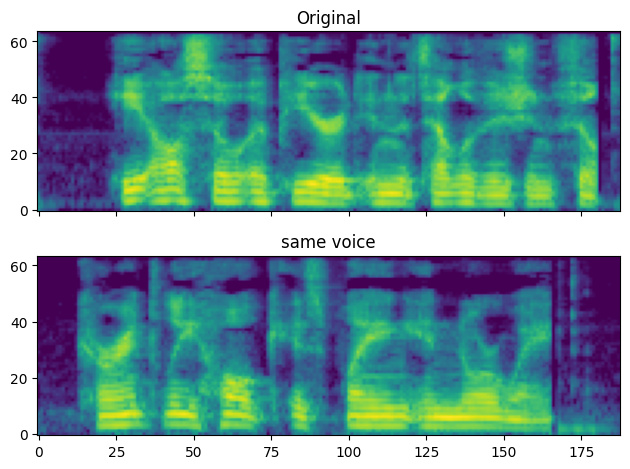

In [29]:
from src.utils.plot import plot

plot(train_ds[789])

In [30]:
class SiameseNetwork(nn.Module):
		def __init__(self):
				super(SiameseNetwork, self).__init__()
				self.conv_layers = nn.Sequential(
						nn.Conv2d(1, 32, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(32, 64, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(64, 128, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(128, 256, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
				)
				self.fc_layers = nn.Sequential(
						nn.Linear(4608, 1024),
						nn.ReLU(inplace=True),
				)

				self.final = nn.Linear(1024, 2)

		def forward_once(self, x):

				x = self.conv_layers(x)
				x = x.view(x.size(0), -1)
				x = self.fc_layers(x)
				return x

		def forward(self, input1, input2):
			output1 = self.forward_once(input1)
			output2 = self.forward_once(input2)
			return self.final(torch.abs(output1 - output2))

In [31]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def evaluate_siamese_model(model, dataloader, criterion, device='cpu'):
	model.eval()
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred) for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]

	accuracy = accuracy_score(true_labels, predictions)
	precision = precision_score(true_labels, predictions)
	recall = recall_score(true_labels, predictions)
	f1 = f1_score(true_labels, predictions)

	avg_loss = total_loss / len(dataloader)

	return avg_loss, accuracy, precision, recall, f1

In [33]:
def train_siamese_model(model, dataloader, criterion, optimizer, device='cpu'):
	model.train()
	total_loss = 0.0
	predictions = []
	true_labels = []

	for batch in tqdm(dataloader, desc="Training", leave=False):
		anchor_sgram, posneg_sgram, label = batch
		anchor_sgram = anchor_sgram.to(device)
		posneg_sgram = posneg_sgram.to(device)
		label = label.to(device)
		
		optimizer.zero_grad()
		output = model(anchor_sgram, posneg_sgram)
		loss = criterion(output, label)
		loss.backward()
		optimizer.step()
		total_loss += loss.item()
		predictions += [torch.argmax(pred) for pred in output.cpu()]
		true_labels += [label.item() for label in label.cpu()]

	accuracy = accuracy_score(true_labels, predictions)
	precision = precision_score(true_labels, predictions)
	recall = recall_score(true_labels, predictions)
	f1 = f1_score(true_labels, predictions)

	avg_loss = total_loss / len(dataloader)
	avg_loss = total_loss / len(dataloader)
	
	return avg_loss, accuracy, precision, recall, f1

In [34]:
class CrossEntropyLoss(torch.nn.Module):
	def __init__(self):
		super(CrossEntropyLoss, self).__init__()

	def forward(self, output, label):
		label = label.long()
		loss = F.cross_entropy(output, label)
		return loss

In [35]:
num_epochs = 10
siamese_model = SiameseNetwork().to('cuda')
criterion = CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
import copy
best_accuracy = 0
loss, accuracy, precision, recall, f1 = [], [], [], [], []
for epoch in range(num_epochs):
	_train_loss, _train_accuracy, _train_precision, _train_recall, _train_f1 = train_siamese_model(siamese_model, train_dl, criterion, optimizer, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_train_loss:.4f}, "f"Accuracy: {_train_accuracy:.4f}, Precision: {_train_precision:.4f}, Recall: {_train_recall:.4f}, F1: {_train_f1:.4f}")
	_test_loss, _test_accuracy, _test_precision, _test_recall, _test_f1 = evaluate_siamese_model(siamese_model, test_dl, criterion, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}, "f"Accuracy: {_test_accuracy:.4f}, Precision: {_test_precision:.4f}, Recall: {_test_recall:.4f}, F1: {_test_f1:.4f}")
	if _test_accuracy > best_accuracy:
		best_accuracy = _test_accuracy
		best_model = copy.deepcopy(siamese_model)
	loss.append([_train_loss, _test_loss])
	accuracy.append([_train_accuracy, _test_accuracy])
	precision.append([_train_precision, _test_precision])
	recall.append([_train_recall, _test_recall])
	f1.append([_train_f1, _test_f1])


Epoch 1/10, Loss: 0.6282, Accuracy: 0.6165, Precision: 0.6330, Recall: 0.5543, F1: 0.5911


Epoch 1/10, Loss: 0.5961, Accuracy: 0.6722, Precision: 0.6590, Recall: 0.7137, F1: 0.6853


Epoch 2/10, Loss: 0.5611, Accuracy: 0.7022, Precision: 0.6988, Recall: 0.7109, F1: 0.7048


Epoch 2/10, Loss: 0.6114, Accuracy: 0.6680, Precision: 0.6328, Recall: 0.8008, F1: 0.7070


Epoch 3/10, Loss: 0.5079, Accuracy: 0.7573, Precision: 0.7444, Recall: 0.7837, F1: 0.7635


Epoch 3/10, Loss: 0.5306, Accuracy: 0.7365, Precision: 0.7436, Recall: 0.7220, F1: 0.7326


Epoch 4/10, Loss: 0.4674, Accuracy: 0.7777, Precision: 0.7562, Recall: 0.8196, F1: 0.7866


Epoch 4/10, Loss: 0.5390, Accuracy: 0.7282, Precision: 0.6950, Recall: 0.8133, F1: 0.7495


Epoch 5/10, Loss: 0.4544, Accuracy: 0.7900, Precision: 0.7666, Recall: 0.8338, F1: 0.7988


Epoch 5/10, Loss: 0.4934, Accuracy: 0.7718, Precision: 0.7610, Recall: 0.7925, F1: 0.7764


Epoch 6/10, Loss: 0.4159, Accuracy: 0.8081, Precision: 0.7830, Recall: 0.8523, F1: 0.8162


Epoch 6/10, Loss: 0.5298, Accuracy: 0.7552, Precision: 0.7189, Recall: 0.8382, F1: 0.7739


Epoch 7/10, Loss: 0.4040, Accuracy: 0.8178, Precision: 0.7952, Recall: 0.8562, F1: 0.8246


Epoch 7/10, Loss: 0.4831, Accuracy: 0.7635, Precision: 0.7396, Recall: 0.8133, F1: 0.7747


Epoch 8/10, Loss: 0.3663, Accuracy: 0.8446, Precision: 0.8225, Recall: 0.8789, F1: 0.8498


Epoch 8/10, Loss: 0.5702, Accuracy: 0.7427, Precision: 0.7082, Recall: 0.8257, F1: 0.7625


Epoch 9/10, Loss: 0.3670, Accuracy: 0.8359, Precision: 0.8108, Recall: 0.8764, F1: 0.8423


Epoch 9/10, Loss: 0.5831, Accuracy: 0.7365, Precision: 0.6887, Recall: 0.8631, F1: 0.7661


Epoch 10/10, Loss: 0.3500, Accuracy: 0.8468, Precision: 0.8267, Recall: 0.8775, F1: 0.8513


Epoch 10/10, Loss: 0.5259, Accuracy: 0.7780, Precision: 0.7326, Recall: 0.8755, F1: 0.7977


In [41]:
import matplotlib.pyplot as plt

def plot_metrix(loss, accuracy):
	epochs = range(1, len(loss) + 1)

	fig, axs = plt.subplots(2, 1, figsize=(12, 8))
	fig.suptitle("Model Metrics")


	axs[0].plot(epochs, [e[0] for e in loss], label=" Train loss", color="g")
	axs[0].plot(epochs, [e[1] for e in loss], label="Test loss", color="b")
	axs[0].set_title("Loss")
	axs[0].set_xlabel("Epoch")
	axs[0].set_ylabel("Loss")

	axs[1].plot(epochs, [e[0] for e in accuracy], label="Train accuracy", color="g")
	axs[1].plot(epochs, [e[1] for e in accuracy], label="Test accuracy", color="b")
	axs[1].set_title("Accuracy")
	axs[1].set_xlabel("Epoch")
	axs[1].set_ylabel("Accuracy")
	plt.tight_layout()
	plt.show()

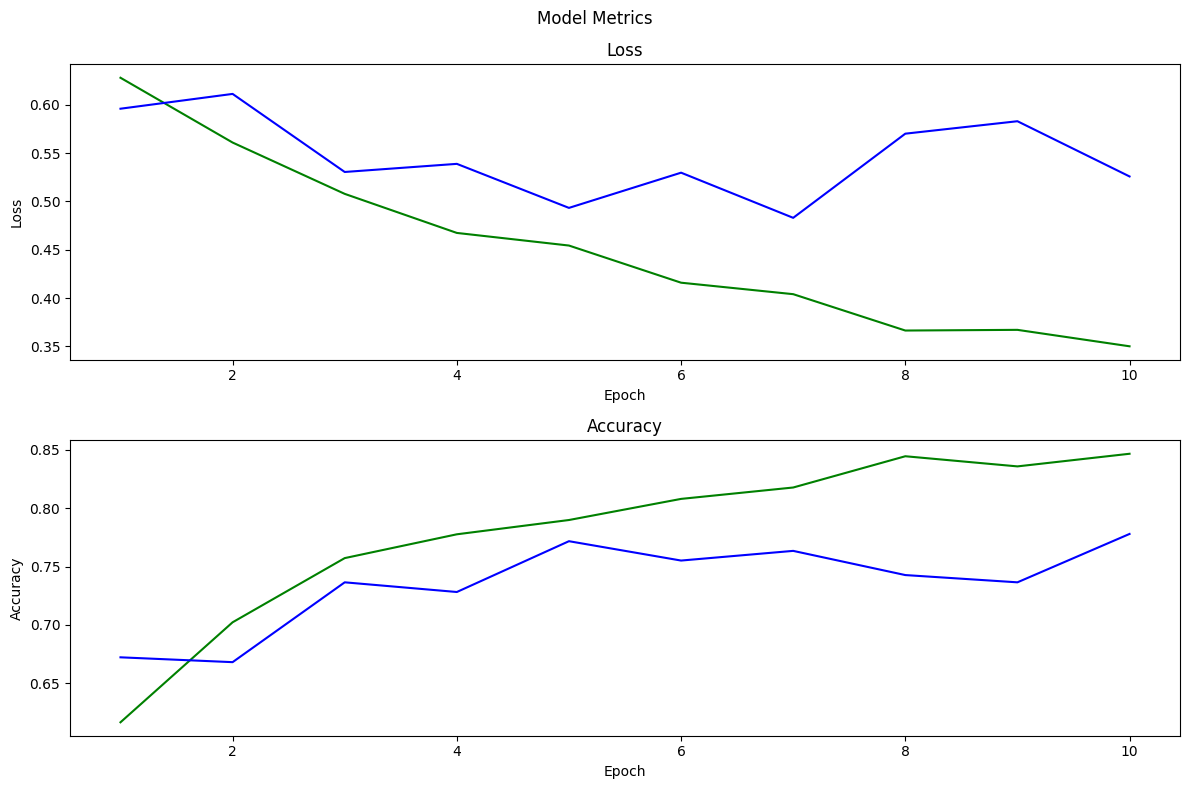

In [42]:
plot_metrix(loss, accuracy)

In [44]:
def save_model(model, model_name, base_path = '../model_save/'):
	model.cpu()
	model.eval()
	torch.save(model, base_path + model_name)

In [45]:
save_model(siamese_model, "base_cnn_augmented.pt")

In [46]:
def explain_model(model: torch.nn.Module, anchor_sgram: torch.tensor, posneg_sgram: torch.tensor, mode: str = "PREDICTED"):
	allowed_mode = ["GENERATED_CLASS, ORIGIN_CLASS", "PREDICTED"]
	if mode not in allowed_mode:
		raise ValueError()
	model.eval()
	model.cpu()
	anchor_sgram = torch.clone(anchor_sgram)
	posneg_sgram = torch.clone(posneg_sgram)

	anchor_sgram.unsqueeze_(0)
	posneg_sgram.unsqueeze_(0)
	anchor_sgram.requires_grad = True
	posneg_sgram.requires_grad = True

	anchor_sgram = anchor_sgram
	posneg_sgram = posneg_sgram

	predictions = model(anchor_sgram, posneg_sgram)
	if mode == "PREDICTED":
		class_id = predictions[0].argmax()
	if mode == "GENERATED_CLASS":
		class_id = 0
	if mode == "ORIGIN_CLASS":
		class_id = 1
	neuron = predictions[0, class_id]

	neuron.retain_grad()
	neuron.backward()
	anchor_slc, _ = torch.max(torch.abs(anchor_sgram.grad[0]), dim=0)
	anchor_grad = (anchor_slc - anchor_slc.min())/(anchor_slc.max()-anchor_slc.min())

	posneg_slc, _ = torch.max(torch.abs(posneg_sgram.grad[0]), dim=0)
	posneg_grad = (posneg_slc - posneg_slc.min())/(posneg_slc.max()-posneg_slc.min())

	return anchor_grad, posneg_grad

In [47]:

def plot_explain_siamese_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad):
	plt.figure(figsize=(10, 2))
	plt.subplot(1, 2, 1)
	plt.title("Anchor Sgram")
	plt.imshow(anchor_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.title("Anchor Sgram Grad")
	plt.imshow(anchor_sgram_grad.numpy(), cmap=plt.cm.hot,
				 origin="lower", aspect="auto")
	plt.figure(figsize=(10, 2))
	plt.subplot(1, 2, 1)
	plt.title("PosNeg Sgram")
	plt.imshow(posneg_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.title("PosNeg Sgram Grad")
	plt.imshow(posneg_sgram_grad.numpy(), cmap=plt.cm.hot,
				 origin="lower", aspect="auto")
	plt.show()

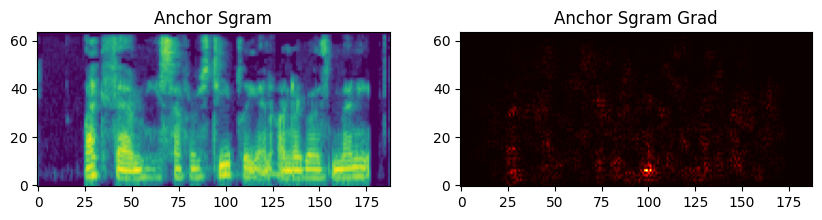

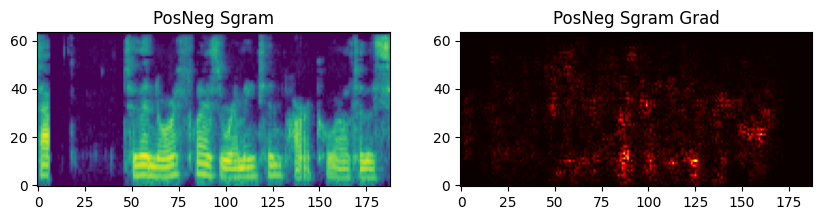

In [48]:
from src.utils.plot import plot_explain_siamese_model_all

anchor_sgram, posneg_sgram, _ = test_ds[4]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_model_all(anchor_sgram[0], posneg_sgram[0], anchor_sgram_grad, posneg_sgram_grad)

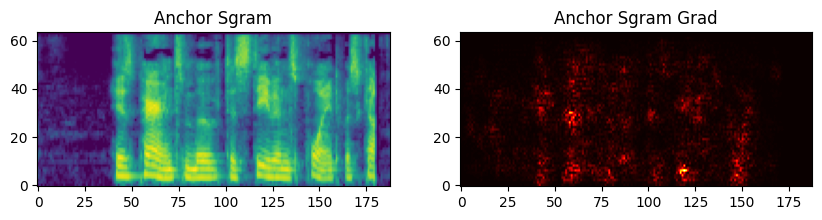

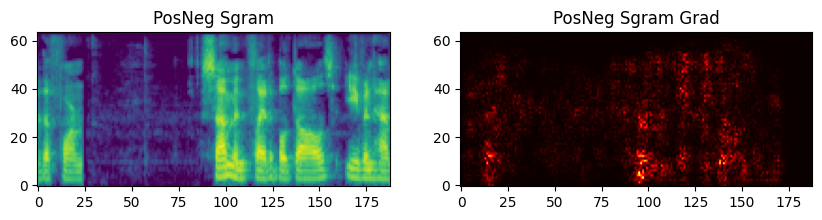

In [49]:
from src.utils.plot import plot_explain_siamese_model_all

anchor_sgram, posneg_sgram, _ = train_ds[0]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_model_all(anchor_sgram[0], posneg_sgram[0], anchor_sgram_grad, posneg_sgram_grad)

In [50]:
def test(model, dataloader, criterion, device='cpu'):
	model.eval()
	model.to(device)
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred).item() for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]


	avg_loss = total_loss / len(dataloader)

	return avg_loss, true_labels, predictions

In [86]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def displayConfusionMatrix(true_labels, predictions):
	matrix = confusion_matrix(y_true=true_labels, y_pred= predictions, normalize="true" )
	disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels = ["Negative","Positive"]) 
	disp.plot(cmap=plt.cm.Blues) 
	plt.show()


In [87]:
test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = BaseSoundDS(test_df, DATA_PATH + "validated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.7946058091286307


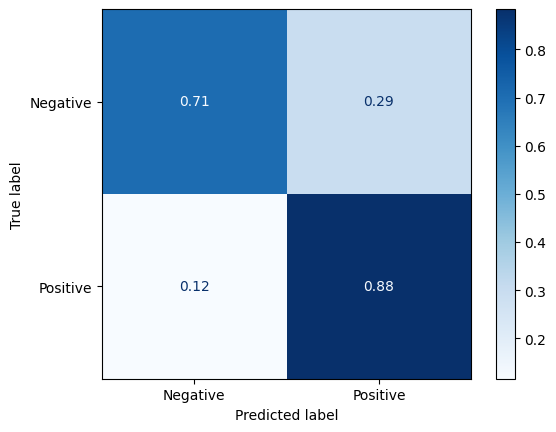

In [88]:
avg_loss, true_labels, predictions = test(best_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

accuracy: 0.8540482954545454


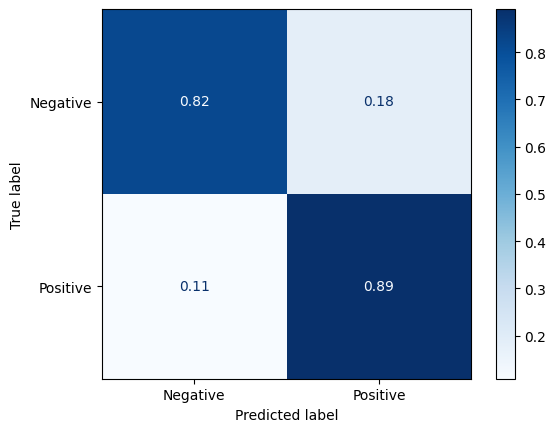

In [89]:
avg_loss, true_labels, predictions = test(best_model, train_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [90]:
from src.dataset.generated_dataset import GeneratedSoundDS

test_df = pd.read_csv(DATASET_PATH + "test_generated_dataset_.csv")
test_ds = GeneratedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)


accuracy: 0.6058091286307054


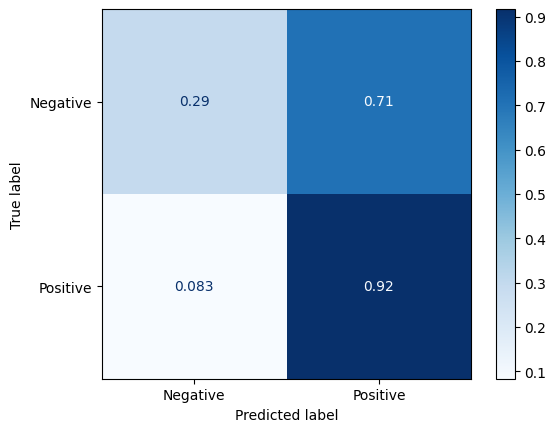

In [91]:
avg_loss, true_labels, predictions = test(best_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [94]:
from src.dataset.combined_dataset import CombinedSoundDS
import librosa

from src.columns.combined_dataset_column import CombinedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class CombinedSoundDS(Dataset):
    def __init__(
        self,
        voiceDataset,
        original_voice_data_path,
        generated_voice_data_path,
        sample_rate=16000,
        duration=3,
        transform=None
    ):
        self.voiceDataset = voiceDataset
        self.original_voice_data_path = str(original_voice_data_path)
        self.generated_voice_data_path = str(generated_voice_data_path)
        self.duration = duration
        self.sample_rate = sample_rate
        self.transform = None
        if transform is not None:
            self.transform = transform
        else:
            self.transform = CompositeTransformation(
                [
                    ResampleTransform(target_sample_rate=sample_rate),
                    CustomAdjustDurationTransform(duration_seconds=duration),
                    ToMelSpectrogramTransform(
                        sample_rate=sample_rate, n_mels=64, n_fft=512)
                ]
            )

    def __len__(self):
        return len(self.voiceDataset)

    def _get_sgram(self, audio_file):
        audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
        spectrogram = self.transform.transform((audio, sample_rate))
        return spectrogram

    def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
        label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
        return torch.tensor(1 if label else 0, dtype=torch.int64)

    def _get_sample_path(self, path, source):
        data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
        return data_path + path

    def __getitem__(self, idx):
        anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.voiceDataset.iloc[idx][
            [
                CombinedDatasetColumn.ANCHOR_PATH,
                CombinedDatasetColumn.POSNEG_PATH,
                CombinedDatasetColumn.ANCHOR_ID,
                CombinedDatasetColumn.POSNEG_ID,
                CombinedDatasetColumn.SOURCE_ANCHOR,
                CombinedDatasetColumn.SOURCE_POSNEG
            ]
        ].values.tolist()

        anchor_file = self._get_sample_path(anchor_path, anchor_source)
        posneg_file = self._get_sample_path(posneg_path, posneg_source)
        label = self._get_label(
            anchor_client_id, posneg_client_id, anchor_source, posneg_source)
        anchor_sgram = self._get_sgram(anchor_file)
        posneg_sgram = self._get_sgram(posneg_file)

        return anchor_sgram, posneg_sgram, label

test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = CombinedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.6901473296500921


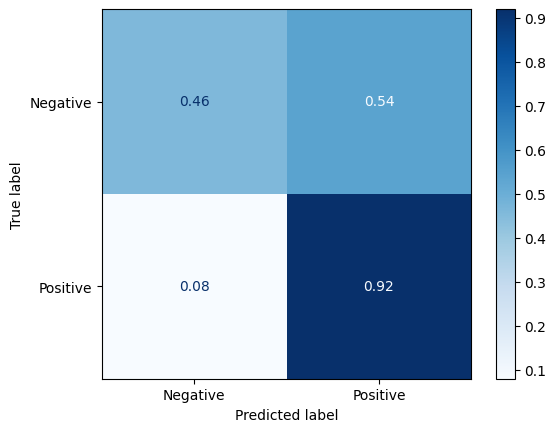

In [95]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [ ]:
SAMPLE_RATE = 16000

In [97]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform
from src.transform.composite_transformation import CompositeTransformation

test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
    #AddGaussianNoiseWrapperTransform(min_amplitude=0.001, max_amplitude=0.005),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)
test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = BaseSoundDS(test_df, DATA_PATH + "validated_16000/",  transform = test_transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.7759336099585062


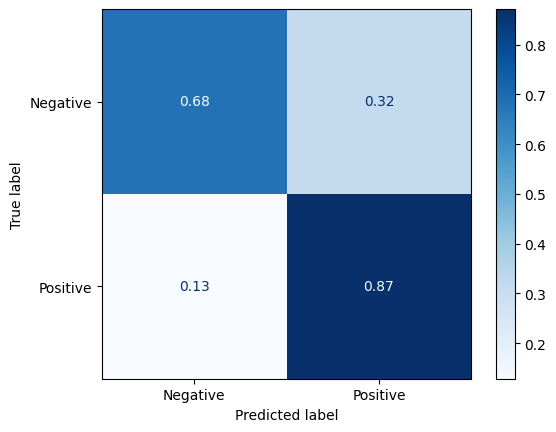

In [98]:
avg_loss, true_labels, predictions = test(best_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)